# Project

1. 수집된 문서 열기(Crawled/Sorted Documnets)
    - 문서 목록 생성
2. 전처리(Preprocessing)
    - (Optional)불필요한 문자 제거(Regular Expression)
    - 토큰화(어절, 음절, N-gram, BPE, 형태소, 품사, 구)
    - 정규화(길이, 빈도, RE)
3. 색인(Indexing) - 문서표현(Document Representation)
    - 색인어 목록 생성
    - 빈도 기반 TDM 생성(역문헌 구조)
    - 색인어 가중치 할당(TF-IDF)
4. 질의(Querying) - 질의표현(Query Representation)
5. 검색 - 벡터공간모델, 확률모델
    - 벡터공간모델(거리, 각도)
    - 확률모델(BM25)
6. 검색결과 확인

# 1. 수집된 문서 열기

## 1.1. 문서 목록 생성

In [1]:
import os

In [18]:
base = "practice/8일차_실습_project/헤드라인"
fileids = [base+"/"+_ for _ in os.listdir(base)
          if len(_.split("-")) > 1]

In [24]:
from collections import defaultdict

naverNews = defaultdict(list)
for fileid in fileids:
    section = fileid.split("/")[-1].split("-")[0]
    fp = open(fileid, "r", encoding="utf-8")
    naverNews[section].append(fp.read())
    fp.close()

In [25]:
naverNews.keys()

dict_keys(['IT 과학', '경제', '사회', '생활 문화', '세계', '정치'])

In [26]:
_Collection = list()
for sec, news in naverNews.items():
    _Collection.extend(news)

In [27]:
len(_Collection)

144

# 2. 전처리

## 2.1. 불필요한 문자 제거(Regular Expression)

In [30]:
import re
from string import punctuation

In [90]:
pattern1 = re.compile(r"// flash.+") # 코드 첫줄 제거
pattern2 = re.compile(r"function.+\{\}") # 코드 두번째 줄 제거
# 특수문자 제거
pattern3 = re.compile("[^A-Za-z가-힣0-9\s{}]".format(punctuation))
pattern4 = re.compile(r"\w+@\w+(?:\.[A-Za-z]{2,3})+") # 이메일 제거

patterns = [pattern1, pattern2, pattern3, pattern4]

In [139]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [113]:
# 테스트

doc = _Collection[0]
for pattern in patterns:
    doc = pattern.sub("", t)

doc

'\n\n\nCJ ENM 및 JTBC.국내 동영상스트리밍서비스(OTT) 시장을 둘러싼 싸움이 대전으로 번지고 있다. 지상파 방송 3사(KBSMBCSBS)와 거대 통신사 SK텔레콤이 합작 OTT 웨이브의 출범(18일)을 알리자마자 국내 대표 케이블채널 사업자인 CJ ENM과 JTBC가 합작 OTT 설립을 발표했다. OTT를 중심으로 한 국내 방송업계 재편이 급물살을 타게 됐다.CJ ENM과 JTBC는 통합 OTT 합작법인을 내년 초까지 출범시키겠다는 내용의 양해각서(MOU)를 체결했다고 17일 밝혔다. 합작법인은 CJ ENM이 1대 주주이며, JTBC가 2대 주주로 참여한다. 통합 OTT는 CJ ENM이 운영하는 OTT 티빙을 기반으로 이뤄질 예정이다. CJ ENM은 인기 케이블채널 tvN과 OCN, 엠넷 등을 보유하고 있는 방송업계 강자다. JTBC는 종합편성(종편) 채널 중 매출액이 가장 높은 방송시장의 신흥 강호다.CJ ENM과 JTBC의 통합 OTT 설립 논의는 지난해부터 이뤄졌다. 세계 최대 OTT인 넷플릭스가 지난해부터 드라마 킹덤 등 국내 콘텐츠 투자에 본격적으로 나서면서부터다. 픽사와 마블 등을 거린 월트 디즈니의 OTT 디즈니플러스가 내년 한국 진출을 예고한 점도 두 회사의 연합을 재촉했다. CJ ENM과 JTBC는 미스터 션샤인과 스카이캐슬 등 자사 인기 콘텐츠의 판권을 넷플릭스에 판매하는 식으로 OTT시장에 진출하는 전략을 취해 왔었다. 국내 동영상 시장이 OTT 위주로 급속히 재편되자 합작 법인 설립으로 전략을 급선회하게 됐다. 웨이브의 출범도 두 회사의 동맹에 큰 영향을 준 것으로 보인다. JTBC 관계자는 방송영상 사업은 속도를 가늠하기 어려울 정도로 빠르게 변화하고 있다며 결국 차별화된 콘텐츠를 끊임없이 생산할 뿐만 아니라, 적절히 유통할 수 이는 시스템 구축이 필수적이라고 밝혔다.두 회사는 콘텐츠에서 상대적 우위를 차지하고 있다. CJ ENM은 시가총액 1억9,000억원대인 국내 최대 드라마 제작사 스튜디오드래곤을 자회사로 두고 있다

In [104]:
# 모든 문서에 적용하기

for i, doc in enumerate(_Collection):
    for pattern in patterns:
        _Collection[i] = pattern.sub("", _Collection[i])

In [501]:
# 모든 문서에 적용하기(naverNews 딕셔너리)

for section in naverNews.keys():
    for i, doc in enumerate(naverNews[section]):
        for pattern in patterns:
            naverNews[section][i] \
            = pattern.sub("", naverNews[section][i])

## 2.2. 토큰화

### 2.2.1. 어절

In [96]:
def eojeol(sentence):
    """문장을 어절 단위로 토큰화 합니다."""
    return sentence.split()

In [98]:
eojeol("안녕 친구")

['안녕', '친구']

In [109]:
from nltk.tokenize import sent_tokenize

def eojeol_tokenizer(corpus):
    """코퍼스를 문장으로 나눈 뒤, 각 문장을 어절 단위로 토큰화합니다."""
    tokens = list()
    for sentence in sent_tokenize(corpus):
        tokens.extend(eojeol(sentence))
    return tokens

In [ ]:
# 테스트

# eojeol_tokenizer(_Collection[0])

### 2.2.2 음절

In [120]:
def eumjeol(sentence):
    """문장을 음절 단위로 토큰화합니다."""
    return [_ for _ in list(sentence) 
            if _ != " " and _ not in punctuation]

In [121]:
eumjeol("안녕하세/요")

['안', '녕', '하', '세', '요']

In [122]:
def eumjeol_tokenizer(corpus):
    """코퍼스를 음절 단위로 토큰화합니다."""
    return eumjeol(corpus)

In [ ]:
# 테스트

# eumjeol_tokenizer(_Collection[0])

### 2.2.3. N-gram

In [151]:
def ngram(sentence, n=2, tokenizer=None):
    """문장을 n-gram으로 만들어 줍니다.
    -----------------
    파라미터 설명:
        - N: 몇개씩 묶을 것인지 정합니다.(기본값=2)
        - tokenizer: 어떤 기준으로 토큰화한 후에 n-gram을 만들 것인지 정합니다. 지정하지 않을 경우 음절 단위로 n-gram을 만듭니다."""
    tokens = []
    if tokenizer:
        sentence = tokenizer(sentence)
    for _ in range(len(sentence) - n + 1):
        tokens.append(sentence[_:_+n])
    return tokens

In [152]:
# 테스트1
ngram("아버지가 방에 들어가신다.")

['아버', '버지', '지가', '가 ', ' 방', '방에', '에 ', ' 들', '들어', '어가', '가신', '신다', '다.']

In [153]:
# 테스트2
ngram("아버지가 방에 들어가신다.", n=2, tokenizer=eojeol)

[['아버지가', '방에'], ['방에', '들어가신다.']]

In [276]:
# 테스트3
result = []
for sentence in sent_tokenize(_Collection[0]):
    result.extend(ngram(sentence))
result

['\n\n',
 '\n\n',
 '\nC',
 'CJ',
 'J ',
 ' E',
 'EN',
 'NM',
 'M ',
 ' 및',
 '및 ',
 ' J',
 'JT',
 'TB',
 'BC',
 'C.',
 '.국',
 '국내',
 '내 ',
 ' 동',
 '동영',
 '영상',
 '상스',
 '스트',
 '트리',
 '리밍',
 '밍서',
 '서비',
 '비스',
 '스(',
 '(O',
 'OT',
 'TT',
 'T)',
 ') ',
 ' 시',
 '시장',
 '장을',
 '을 ',
 ' 둘',
 '둘러',
 '러싼',
 '싼 ',
 ' 싸',
 '싸움',
 '움이',
 '이 ',
 ' 대',
 '대전',
 '전으',
 '으로',
 '로 ',
 ' 번',
 '번지',
 '지고',
 '고 ',
 ' 있',
 '있다',
 '다.',
 '지상',
 '상파',
 '파 ',
 ' 방',
 '방송',
 '송 ',
 ' 3',
 '3사',
 '사(',
 '(K',
 'KB',
 'BS',
 'SM',
 'MB',
 'BC',
 'CS',
 'SB',
 'BS',
 'S)',
 ')와',
 '와 ',
 ' 거',
 '거대',
 '대 ',
 ' 통',
 '통신',
 '신사',
 '사 ',
 ' S',
 'SK',
 'K텔',
 '텔레',
 '레콤',
 '콤이',
 '이 ',
 ' 합',
 '합작',
 '작 ',
 ' O',
 'OT',
 'TT',
 'T ',
 ' 웨',
 '웨이',
 '이브',
 '브의',
 '의 ',
 ' 출',
 '출범',
 '범(',
 '(1',
 '18',
 '8일',
 '일)',
 ')을',
 '을 ',
 ' 알',
 '알리',
 '리자',
 '자마',
 '마자',
 '자 ',
 ' 국',
 '국내',
 '내 ',
 ' 대',
 '대표',
 '표 ',
 ' 케',
 '케이',
 '이블',
 '블채',
 '채널',
 '널 ',
 ' 사',
 '사업',
 '업자',
 '자인',
 '인 ',
 ' C',
 'CJ',
 'J ',
 ' E',
 

### 2.2.4. BPE

In [215]:
example = ["방탄소년단",
          "방탄모",
          "우주소년단",
          "우주소녀",
          "우주비행선"]

example = [" ".join(eumjeol(_)+["</w>"]) for _ in example]
example

['방 탄 소 년 단 </w>',
 '방 탄 모 </w>',
 '우 주 소 년 단 </w>',
 '우 주 소 녀 </w>',
 '우 주 비 행 선 </w>']

In [224]:
from collections import defaultdict

temp = defaultdict(int)
for word in example:
    for pair in ngram(word.split()):
        temp[tuple(pair)] += 1
temp

defaultdict(int,
            {('방', '탄'): 2,
             ('탄', '소'): 1,
             ('소', '년'): 2,
             ('년', '단'): 2,
             ('단', '</w>'): 2,
             ('탄', '모'): 1,
             ('모', '</w>'): 1,
             ('우', '주'): 3,
             ('주', '소'): 2,
             ('소', '녀'): 1,
             ('녀', '</w>'): 1,
             ('주', '비'): 1,
             ('비', '행'): 1,
             ('행', '선'): 1,
             ('선', '</w>'): 1})

In [223]:
maxPair = max(temp, key=temp.get)
maxPair

('우', '주')

In [228]:
for i, _ in enumerate(example):
    example[i] = re.sub(" ".join(maxPair), "".join(maxPair), _)  
example

['방 탄 소 년 단 </w>',
 '방 탄 모 </w>',
 '우주 소 년 단 </w>',
 '우주 소 녀 </w>',
 '우주 비 행 선 </w>']

In [229]:
# 반복 수행

for i in range(5):
    temp = defaultdict(int)

    for word in example:
        for pair in ngram(word.split()):
            temp[tuple(pair)] += 1

    maxPair = max(temp, key=temp.get)

    for i, _ in enumerate(example):
        example[i] = re.sub(" ".join(maxPair), "".join(maxPair), _) 

example

['방탄소년단</w>', '방탄 모 </w>', '우주 소년단</w>', '우주 소 녀 </w>', '우주 비 행 선 </w>']

In [268]:
# 데이터가 단어와 빈도수로 구성되어 있는 경우

example2 = {"방탄소년단":4,
          "방탄모":2,
          "우주소년단":5,
          "우주소녀":6,
          "우주비행선":3}

example2 = {" ".join(eumjeol(word)+["</w>"]):freq 
            for word, freq in example2.items()}
example2

{'방 탄 소 년 단 </w>': 4,
 '방 탄 모 </w>': 2,
 '우 주 소 년 단 </w>': 5,
 '우 주 소 녀 </w>': 6,
 '우 주 비 행 선 </w>': 3}

In [269]:
# 데이터가 달라짐에 따라 조금 수정함!

temp = defaultdict(int)
for word, freq in example2.items():
    pairs = ngram(word.split())
    for pair in pairs:
        temp[tuple(pair)] += freq

maxPair = max(temp, key=temp.get)

result = dict()
for word, freq in example2.items():
    newWord = re.sub(" ".join(maxPair), "".join(maxPair), word)
    result[newWord] = freq

example2 = result
example2

{'방 탄 소 년 단 </w>': 4,
 '방 탄 모 </w>': 2,
 '우주 소 년 단 </w>': 5,
 '우주 소 녀 </w>': 6,
 '우주 비 행 선 </w>': 3}

In [273]:
# 반복수행

# limit 추가
threshold = max(example2.values())

for _ in range(100):
    temp = defaultdict(int)
    for word, freq in example2.items():
        pairs = ngram(word.split())
        for pair in pairs:
            temp[tuple(pair)] += freq

    maxPair = max(temp, key=temp.get)

    if temp[maxPair] > threshold:
        result = dict()
        for word, freq in example2.items():
            newWord = re.sub(" ".join(maxPair), "".join(maxPair), word)
            result[newWord] = freq

        example2 = result

example2

{'방 탄 소 년단</w>': 4,
 '방 탄 모 </w>': 2,
 '우주소 년단</w>': 5,
 '우주소 녀 </w>': 6,
 '우주 비 행 선 </w>': 3}

In [ ]:
# 테스트

from nltk.text import Text
from nltk.tokenize import word_tokenize

text = Text(word_tokenize(_Collection[0]))
text = {" ".join(list(word)+["</w>"]):freq
    for word, freq in text.vocab().items()}

threshold = max(text.values())

for _ in range(100):
    temp = defaultdict(int)
    for word, freq in text.items():
        pairs = ngram(word.split())
        for pair in pairs:
            temp[tuple(pair)] += freq

    maxPair = max(temp, key=temp.get)
    print(maxPair, temp[maxPair])

    if temp[maxPair] > threshold:
        result = dict()
        for word, freq in text.items():
            newWord = re.sub(" ".join(maxPair), "".join(maxPair), word)
            result[newWord] = freq
    else:
        break
    
    text = result
    
# result

### 2.2.5. 형태소

In [155]:
from konlpy.tag import Kkma
kkma = Kkma()

C:\Users\JINHYO\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [159]:
kkma.morphs("아버지가 방에 들어가신다")

['아버지', '가', '방', '에', '들어가', '시', 'ㄴ다']

In [414]:
corpus = ""
# for news in naverNews["정치"]:
for news in _Collection:
    corpus += news

_Vocabulary = kkma.morphs(corpus)

### 2.2.6. 품사

In [157]:
kkma.pos("아버지가 방에 들어가신다")

[('아버지', 'NNG'),
 ('가', 'JKS'),
 ('방', 'NNG'),
 ('에', 'JKM'),
 ('들어가', 'VV'),
 ('시', 'EPH'),
 ('ㄴ다', 'EFN')]

In [ ]:
# mecab도 있어요...

### 2.2.7. 구

In [ ]:
# 잘 모르겠어요... 나중에 다시 올게요;;

## 2.3 정규화

### 2.3.1. 빈도

In [415]:
text = Text(_Vocabulary) # kkma 형태소 분석한 _Vocabulary 사용

In [416]:
text.vocab().B(), text.vocab().N()

(8407, 118349)

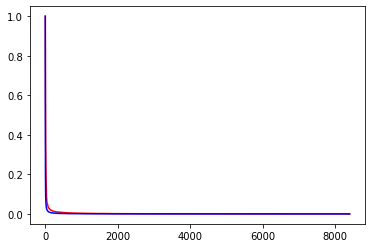

In [417]:
# zipf's law
import matplotlib.pyplot as plt

freqOrder = [_[1]/text.vocab()[text.vocab().max()] 
             for _ in text.vocab().most_common()]
reverseOrder = [1/_ for _ in range(1, text.vocab().B()+1)]

plt.plot(freqOrder, "r-")
plt.plot(reverseOrder, "b-")

In [418]:
# 상위 20퍼센트단어
frac = int(text.vocab().B()*0.2)
high20 = text.vocab().most_common(frac)
high20

[('하', 4444),
 ('이', 3675),
 ('.', 3281),
 ('ㄴ', 2915),
 ('다', 2624),
 ('는', 2538),
 ('을', 2450),
 ('었', 2040),
 ('에', 1827),
 ('를', 1513),
 ('은', 1486),
 ('의', 1467),
 ('고', 1445),
 ('어', 1425),
 (',', 1125),
 ('가', 1075),
 ('"', 1072),
 ('있', 1063),
 ('되', 995),
 ('에서', 988),
 ('ㄹ', 892),
 ('으로', 880),
 ('도', 776),
 ('것', 743),
 ('(', 655),
 (')', 654),
 ("'", 654),
 ('로', 610),
 ('일', 542),
 ('과', 531),
 ('지', 496),
 ('들', 446),
 ('아', 428),
 ('ㄴ다', 410),
 ('수', 388),
 (']', 360),
 ('등', 356),
 ('[', 352),
 ('기', 350),
 ('와', 316),
 ('게', 309),
 ('만', 296),
 ('기자', 288),
 ('장관', 277),
 ('김', 267),
 ('며', 266),
 ('뉴스', 266),
 ('1', 262),
 ('면', 248),
 ('전', 245),
 ('않', 243),
 ('다고', 242),
 ('대하', 238),
 ('돼지', 238),
 ('콘텐츠', 232),
 ('17', 227),
 ('조', 223),
 ('서울', 221),
 ('원', 220),
 ('나', 218),
 ('대표', 215),
 ('보', 215),
 ('대통령', 214),
 ('월', 212),
 ('라고', 205),
 ('한국', 202),
 ('더', 202),
 ('았', 197),
 ('%', 196),
 ('년', 192),
 ('까지', 189),
 ('위하', 180),
 ('당', 180),
 ('시', 174),


In [419]:
# 하위 20퍼센트 단어

low20 = sorted(text.vocab().most_common(), key=lambda x:x[1])[:frac]
low20

[('KBSMBCSBS', 1),
 ('물살', 1),
 ('각서', 1),
 ('MOU', 1),
 ('강자', 1),
 ('종편', 1),
 ('신흥', 1),
 ('강호', 1),
 ('덤', 1),
 ('픽', 1),
 ('월트', 1),
 ('재촉', 1),
 ('션샤인', 1),
 ('스카이', 1),
 ('캐슬', 1),
 ('급속히', 1),
 ('급선회', 1),
 ('가늠', 1),
 ('총액', 1),
 ('9,000', 1),
 ('삼시', 1),
 ('세끼', 1),
 ('배급', 1),
 ('영화계', 1),
 ('큰손', 1),
 ('하며', 1),
 ('관계인', 1),
 ('비책', 1),
 ('3,000', 1),
 ('긴밀', 1),
 ('7,900', 1),
 ('책정', 1),
 ('9,500', 1),
 ('회원', 1),
 ('이메일', 1),
 ('카톡', 1),
 ('스케줄', 1),
 ('죠르디', 1),
 ('게임인', 1),
 ('댑도', 1),
 ('댑최', 1),
 ('셀러', 1),
 ('참여도', 1),
 ('저변', 1),
 ('앞장서', 1),
 ('손잡', 1),
 ('서비스인', 1),
 ('NHN', 1),
 ('IT', 1),
 ('노하우', 1),
 ('경력자', 1),
 ('메타', 1),
 ('토토', 1),
 ('188', 1),
 ('이드', 1),
 ('찾아보', 1),
 ('심의제', 1),
 ('제인', 1),
 ('애', 1),
 ('팡이', 1),
 ('폭발적', 1),
 ('커스', 1),
 ('디앱', 1),
 ('탑', 1),
 ('재하', 1),
 ('도저버드간', 1),
 ('고양이', 1),
 ('토키', 1),
 ('스테이트', 1),
 ('댑스', 1),
 ('플레이스', 1),
 ('베타', 1),
 ('체임', 1),
 ('절감', 1),
 ('주세', 1),
 ('편리', 1),
 ('손쉽', 1),
 ('톡에', 1),
 ('목과', 1),
 ('죠르',

In [ ]:
# 상위, 하위 20개 단어 삭제
# => 빈도로 삭제하기에는 아직 corpus가 적은 것 같음; 생략;

# high20 = [_[0] for _ in high20]
# low20 = [_[0] for _ in low20]

# _Vocabulary = [_ for _ in _Vocabulary 
#               if not _ in high20 
#                and _ not in low20]

# len(_Vocabulary)

### 2.3.2. 길이

In [518]:
# 1절 초과 7음절 미만 만 남긴다.

print(len(_Vocabulary))
_Vocabulary = [_ for _ in _Vocabulary if 1 < len(_) < 7]
len(_Vocabulary)

118349


53427

### 2.3.3. RE

In [ ]:
# 뭘 해야 하는 걸까....

# 3. 색인(Indexing) - 문서표현(Document Representation)

## 3.1.색인어 목록 생성

In [ ]:
# 뭘 하면 되는 거죠...?
# DTM을 만들면 되나요...?

## 3.2. 빈도 기반 TDM 생성(역문헌 구조)

In [519]:
from struct import pack, unpack

_Document = defaultdict(
    lambda:{"vec_len":0.0, "ttf":0, "maxtf":None}) # document별 tf max 저장용
_Lexicon = defaultdict(lambda: -1) # 최신 ptr 유지용

fp = open("practice/posting_18.dat", "wb")

for doc in naverNews["정치"]:
    _localPosting = defaultdict(int)
    for t in [_ for _ in kkma.morphs(doc)
              if _ in _Vocabulary]: # 전처리한 vocab만 유효한 단어로 보겠음.
        _localPosting[t] += 1
    docID = len(_Document)
    _Document[docID]["maxtf"] = max(_localPosting.values())
    _Document[docID]["ttf"] = sum(_localPosting.values())

    for t, f in _localPosting.items():
        ptr = _Lexicon[t]
        nextPtr = fp.tell()
        fp.write(pack("iii", docID, f, ptr))
        _Lexicon[t] = nextPtr
fp.close()

## 3.3. 색인어 가중치 할당(TF-IDF)

In [520]:
# TF-IDF variants: https://en.wikipedia.org/wiki/Tf–idf
from math import log

tf1 = lambda frequency: 1 if frequency else 0 # binary 
tf2 = lambda frequency: frequency # raw count
tf3 = lambda frequency, N: frequency / N # term frequency
tf4 = lambda frequency: log(1 + frequency) # log normalization
tf6 = lambda frequency, maxtf, k: k+(1-k)*(frequency/maxtf) # double normalization k
tf5 = lambda frequency, maxtf: tf6(frequency, maxtf, 0.5) # double normaliztion 0.5

idf1 = lambda df, N: 1 # unary
idf2 = lambda df, N: log(N/df) # inverse document frequency
idf3 = lambda df, N: log(N/(1+df)) # inverse document frequency smooth
idf4 = lambda df, N, maxdf: log(maxdf/(1+df)) # inverse document frequency max
idf5 = lambda df, N: log((N-df)/df) # probabilistic inverse document frequency

In [521]:
distance = lambda x1, x2:(x1-x2)**2

In [522]:
N = len(naverNews["정치"])
_WLexicon = defaultdict(lambda:{"pointer":None, "df":0})

fp = open("practice/posting_18.dat", "rb")
wp = open("practice/weight_18.dat", "wb")

for t, ptr in _Lexicon.items():
    dfPtr = ptr
    df = 0
    while dfPtr != -1:
        fp.seek(dfPtr)
        _struct = unpack("iii", fp.read(4*3))
        df += 1
        dfPtr = _struct[-1]

    wptr = wp.tell()
    while ptr != -1:
        fp.seek(ptr)
        _struct = unpack("iii", fp.read(4*3))
        frequency = _struct[1]
        docID = _struct[0]
        maxtf = _Document[docID]["maxtf"]
        w = tf6(frequency, maxtf, 0) * idf3(df, N)
        
        _Document[docID]["vec_len"] += distance(0,w)

        wp.write(pack("if", docID, w))
        ptr = _struct[-1]
    _WLexicon[t]["pointer"] = wptr 
    _WLexicon[t]["df"] = df

fp.close()
wp.close()

# 4. 질의(Querying) - 질의표현(Query Representation)

In [523]:
Query = "조국 법무부 장관 임명에 반발한 야당 인사들의 삭발 행렬은 앞으로도 이어질 것으로 보인다"
_QueryRepr = defaultdict(int) # query representation
_QueryLength = 0.0 # query vector length
_QueryWeight = defaultdict(float) # query term weights

for t in [_ for _ in kkma.morphs(Query) 
          if _ in _Vocabulary]:
    _QueryRepr[t] += 1

maxQuery = max(_QueryRepr.values())

for t, f in _QueryRepr.items():
    df = _WLexicon[t]["df"]
    qw = tf6(f, maxQuery, 0) * idf3(df, N)
    _QueryWeight[t] = qw
    _QueryLength += distance(0, qw)

# 5. 검색 - 벡터공간모델, 확률모델

## 5.1. 벡터공간모델

### 5.1.1. 거리

In [549]:
# Euclidean distance

from math import sqrt

wp = open("practice/weight_18.dat", "rb")
result = defaultdict(float)

for t, _struct in _WLexicon.items():
    ptr = _struct["pointer"]
    df = _struct["df"]
    wp.seek(ptr)
    dw = 0
    for i in range(df):
        _Wstruct = unpack("if", wp.read(4*2))
        docID = _Wstruct[0]
        dw = _Wstruct[1]
        qw = _QueryWeight[t]
        result[docID] += distance(dw, qw)

wp.close()
        
result = {docID:sqrt(distance) for docID, distance in result.items()}

In [550]:
# 유클리드 거리는 각도를 고려하지 않기 때문에 성능이 다소 떨어진다.

sorted(result.items(), key=lambda x:x[1], reverse=True)

[(22, 5.974079915528686),
 (11, 5.77255851226582),
 (5, 5.225202535856213),
 (25, 5.11447236300986),
 (4, 4.56090164942437),
 (6, 4.482898819649304),
 (15, 4.265318976225882),
 (26, 4.223650338290155),
 (16, 4.197563788942194),
 (24, 4.139484061356345),
 (3, 3.761520119391956),
 (23, 3.6793287396798795),
 (8, 3.4703935353533684),
 (2, 3.418313148175054),
 (1, 3.1955082858947046),
 (14, 3.135578866924067),
 (19, 3.0648289677586438),
 (0, 2.7346614946444716),
 (10, 2.4990527343654305),
 (28, 2.4794729159511295),
 (29, 2.4767541827583965),
 (18, 2.447516154704379),
 (9, 2.4255394938302817),
 (12, 2.3747406692514352),
 (27, 2.219661089970015),
 (13, 2.199377659854367),
 (17, 2.1614751375968044),
 (7, 2.0157219618849735),
 (20, 1.9720320137095888),
 (21, 1.8272451986328495)]

### 5.1.2. 각도

https://ko.wikipedia.org/wiki/코사인_유사도

$$
similarity 
= cos{\theta}
= \frac{A \cdot B}{||A|| \space ||B||} 
= \frac{\sum_{i=1}^n{A_i \times B_i}}{\sqrt{\sum_{i=1}^n{(A_i)^2}} \times \sqrt{\sum_{i=1}^n{(B_i)^2}}}
$$

In [544]:
# Cosine similarity

result = defaultdict(float)

wp = open("practice/weight_18.dat", "rb")
for t, _struct in _WLexicon.items():
    ptr = _struct["pointer"]
    df = _struct["df"]
    
    wp.seek(ptr)
    for i in range(df):
        _Wstruct = unpack("if", wp.read(4*2))
        docID = _Wstruct[0]
        dw = _Wstruct[1]
        qw = _QueryWeight[t]
        result[docID] += qw * dw
wp.close()

result = {t:dist/(sqrt(_QueryLength) * sqrt(_Document[docID]["vec_len"]))
            for t, dist in result.items()}

In [548]:
sorted(result.items(), key=lambda x:x[1], reverse=True)

[(6, 0.6232713055007102),
 (1, 0.3066384805965408),
 (14, 0.18391791328853824),
 (18, 0.17940367431278553),
 (27, 0.16287496836381332),
 (21, 0.15983048297829072),
 (8, 0.15199763510572964),
 (26, 0.14747502051823183),
 (10, 0.11507797366658643),
 (17, 0.06833661797328613),
 (9, 0.05993353222956181),
 (20, 0.05667390582008149),
 (24, 0.04936717334116951),
 (13, 0.046891422338440514),
 (7, 0.03817326172541166),
 (25, 0.037348725915591276),
 (3, 0.026080888254627704),
 (15, 0.01872857328485309),
 (19, 0.009934213287282634),
 (11, 0.009296666285569048),
 (5, 0.007581951692441662),
 (23, 0.0070990638797524385),
 (2, 0.0056024911018639455),
 (29, 0.003573079371991935),
 (16, 0.0027964991512272695),
 (22, 0.0020001697274463722),
 (12, 0.0006118596085570947),
 (28, 0.0006086150876756563),
 (0, 0.0004926691157159099),
 (4, 5.421032705745255e-05)]

## 5.2. 확률모델(BM25)

# 6. 검색결과 확인

In [553]:
for i, _ in enumerate(naverNews["정치"]):
    if re.findall(Query, _):
        print("Query: ", Query)
        print()
        print("docID: ", i)
        print(re.sub(Query, "<★★★{}★★★>".format(Query), _))

Query:  조국 법무부 장관 임명에 반발한 야당 인사들의 삭발 행렬은 앞으로도 이어질 것으로 보인다

docID:  6



황교안이언주 등 야당 인사 5명 '조국 퇴진' 삭발 감행 [이명선 기자] 황교안 자유한국당 대표에 이어 김문수 전 경기도지사가 '조국 퇴진' 삭발 행렬에 동참했다. 김 전 지사는 17일 오전 청와대 분수대 앞에서 "단식해보고 감옥(도) 가봤지만, 머리 깎는 것은 처음"이라며 "홍콩보다 더 위대한 대한민국이라는 것을 보여주시길 바란다"고 말한 뒤 삭발을 진행했다.김 전 지사는 삭발 후 눈물을 보이며, "지금 나라도 망가졌고 언론도 망가졌다. 검찰은 잘하고 있다고 생각한다. 한국당은 더 강력한 투쟁으로 문재인(대통령)을 끌어내고 조국(법무부 장관)을 감옥으로 보내는데 더 힘차게 나서주길 바란다"고 부탁했다. 이어 "모든 신앙과 정당, 자기 직업을 초월해 위대한 대한민국을 지켜내자"면서 "한국당에 입당한 후 저도 너무 안락한 생활을 해와서 웰빙 체질이 되고 있다. (대한민국을) 이대로 내버려 둘 수 없다는 생각으로 나라와 우리 어린아이들을 위해 할 수 있는 모든 것을 다 하겠다. 머리밖에 깎을 수 없는 미약함을 용서해달라"고 말했다.<★★★조국 법무부 장관 임명에 반발한 야당 인사들의 삭발 행렬은 앞으로도 이어질 것으로 보인다★★★>. 지난 10일 이언주 무소속 의원이 삭발을 시작한 이래, 11일 박인숙 한국당 의원과 김숙향 동작갑 당협위원장, 16일 황교안 한국당 대표, 그리고 김문수 전 지사 등 지금까지 5명이 삭발을 했다. 이명선 기자 ()프레시안 CMS 정기후원네이버 프레시안 채널 구독 프레시안 기사제보Copyrights PRESSian.com 무단전재 및 재배포금지
